**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img
tf.get_logger().setLevel('ERROR')

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

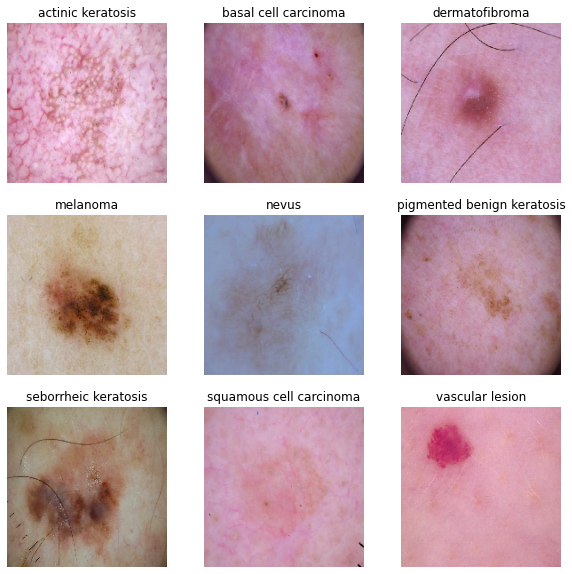

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [10]:
for image_batch,labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 9)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
#Sequential allows you to create models layer-by-layer  
num_classes = 9
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 227s 925ms/step - loss: 2.0463 - accuracy: 0.2651 - val_loss: 1.6840 - val_accuracy: 0.3848
Epoch 2/20
56/56 [==============================] - 2s 37ms/step - loss: 1.6034 - accuracy: 0.4230 - val_loss: 1.5752 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - 2s 35ms/step - loss: 1.4759 - accuracy: 0.4916 - val_loss: 1.6625 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4153 - accuracy: 0.5067 - val_loss: 1.5547 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.3184 - accuracy: 0.5262 - val_loss: 1.4443 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 2s 34ms/step - loss: 1.3776 - accuracy: 0.5140 - val_loss: 1.4395 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.2533 - accuracy: 0.5558 - val_loss: 1.4569 - val_accuracy: 0.5145
Epoch 8/20

### Visualizing training results

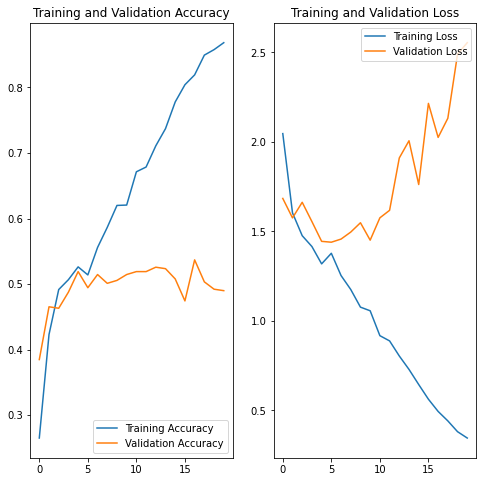

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

1. As we can see from the above result accuracy for training **86%** and for validation **49%**.
2. Training Loss is **0.3453** and Validation Loss is **2.5542**.
3. It is clearly visible that there is overfitting issue.
4. We didn't use any regularisation technique in above model.

### Write your findings here

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, 
# choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal',
                                                 input_shape = (180,180,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

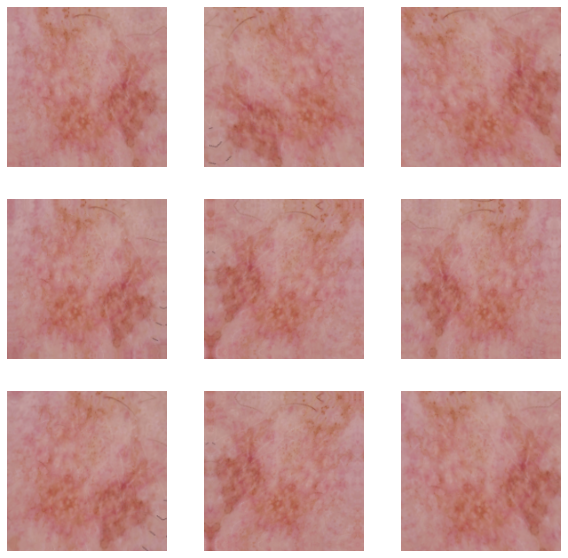

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
def class_distribution_count(directory):
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,nevus,357
2,seborrheic keratosis,77
3,actinic keratosis,114
4,pigmented benign keratosis,462
5,vascular lesion,139
6,dermatofibroma,95
7,basal cell carcinoma,376
8,squamous cell carcinoma,181


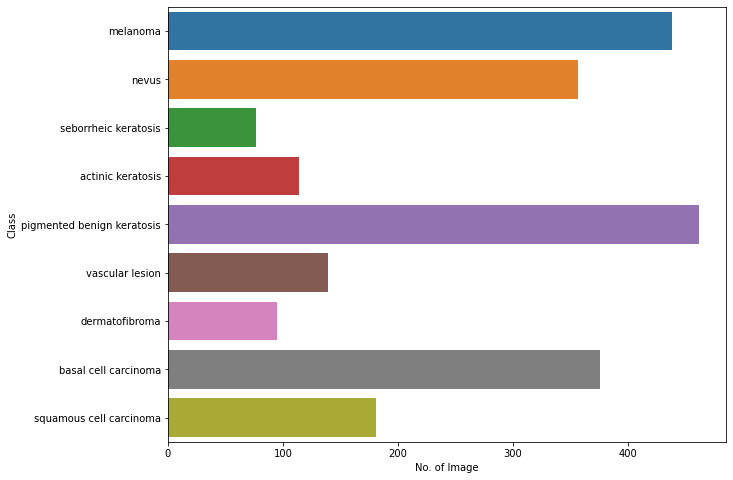

In [20]:
#Visualize the Number of image in each class.

plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")
plt.show()

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.50))

#Dropout layer with 50% Fraction of the input units to drop.
#model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                  

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 15s 182ms/step - loss: 2.1179 - accuracy: 0.2188 - val_loss: 1.9032 - val_accuracy: 0.3445
Epoch 2/20
56/56 [==============================] - 10s 185ms/step - loss: 1.8114 - accuracy: 0.3449 - val_loss: 1.5671 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 10s 187ms/step - loss: 1.6484 - accuracy: 0.4308 - val_loss: 1.7734 - val_accuracy: 0.4049
Epoch 4/20
56/56 [==============================] - 9s 164ms/step - loss: 1.5657 - accuracy: 0.4593 - val_loss: 1.5502 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 10s 182ms/step - loss: 1.4606 - accuracy: 0.4922 - val_loss: 1.4750 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 10s 181ms/step - loss: 1.4416 - accuracy: 0.5112 - val_loss: 1.4456 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 10s 174ms/step - loss: 1.4411 - accuracy: 0.4933 - val_loss: 1.4546 - val_accuracy: 0.5078


### Visualizing the results

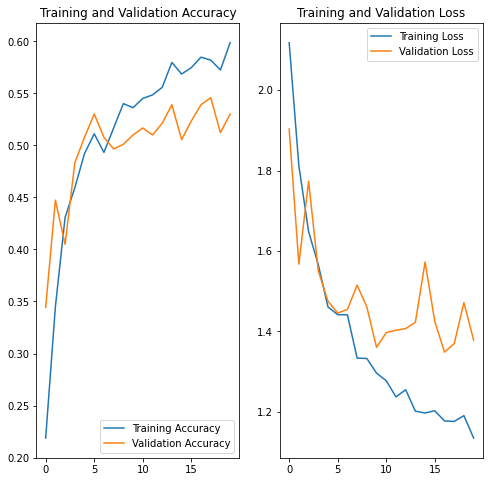

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

 1. Although after doing data augmentation, it removes Overfitting but now model is underfitted as for training and validation **accuracy** is not good.
 2. Training Accuracy reduced to around **60%** and however Validation Accuracy improved little better from **49%** to **53%**, But still overall is not much better.
 3. For Training Loss it became **1.1348** and for Validation Loss it became **1.3784**.
 4. I have added **Dropouts** as well to minimize the complexity but still model doesn't perform well.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

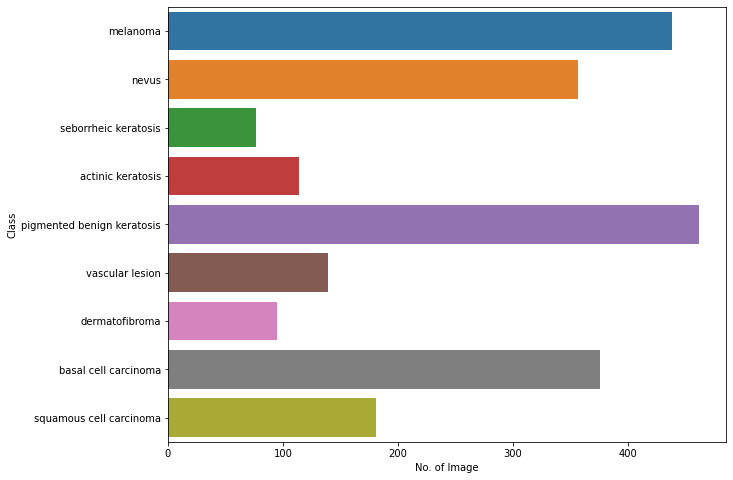

In [26]:
## Your code goes here.
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

###  ``Seaborrheic Keratosis`` class has least number of samples.

#### - Which classes dominate the data in terms proportionate number of samples?

### ``Basal Cell Carcinoma``, ``Melanoma``, ``Nevus`` and ``Pigmented Benign Keratosis`` classes dominate the data in terms of number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="/content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF121898820>: 100%|██████████| 500/500 [00:25<00:00, 19.57 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF121848100>: 100%|██████████| 500/500 [00:26<00:00, 18.63 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF121859DF0>: 100%|██████████| 500/500 [00:23<00:00, 21.12 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FF1218593A0>: 100%|██████████| 500/500 [01:47<00:00,  4.64 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7FF1218133D0>: 100%|██████████| 500/500 [01:32<00:00,  5.42 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF121824430>: 100%|██████████| 500/500 [00:20<00:00, 24.55 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF122606070>: 100%|██████████| 500/500 [00:51<00:00,  9.80 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF1220B27F0>: 100%|██████████| 500/500 [00:21<00:00, 23.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF1220400A0>: 100%|██████████| 500/500 [00:22<00:00, 22.57 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/melanoma/output/melanoma_original_ISIC_0010797.jpg_e095cb67-a94c-4a32-92dd-e3c2cb756032.jpg',
 '/content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/melanoma/output/melanoma_original_ISIC_0000156.jpg_01085ce1-0403-418a-93fc-fb3e97d95f00.jpg',
 '/content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/melanoma/output/melanoma_original_ISIC_0010376.jpg_839e97e9-d4ed-4ea8-b6e8-4f09d32dae1d.jpg',
 '/content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/melanoma/output/melanoma_original_ISIC_0000434.jpg_43015d22-1a40-48d5-9d93-f670f6854aaf.jpg',
 '/content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/melanoma/output/melanoma_original_ISIC_0010321.jpg_28a5b9be-fb08-4a94-a30f-7d0ad190fe9a.jpg',
 '/content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/melanoma

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = df2

In [34]:
new_df['Label'].value_counts()

melanoma                      500
nevus                         500
seborrheic keratosis          500
actinic keratosis             500
pigmented benign keratosis    500
vascular lesion               500
dermatofibroma                500
basal cell carcinoma          500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
data_dir_train="/content/gdrive/MyDrive/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
  )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
  )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
## your code goes here

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.50))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [40]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

#### **Todo:**  Train your model

In [41]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 49s 270ms/step - loss: 2.1515 - accuracy: 0.1727 - val_loss: 1.8653 - val_accuracy: 0.2992
Epoch 2/30
169/169 [==============================] - 35s 199ms/step - loss: 1.6621 - accuracy: 0.3591 - val_loss: 1.4959 - val_accuracy: 0.4209
Epoch 3/30
169/169 [==============================] - 36s 209ms/step - loss: 1.4512 - accuracy: 0.4444 - val_loss: 1.3600 - val_accuracy: 0.4885
Epoch 4/30
169/169 [==============================] - 34s 194ms/step - loss: 1.3207 - accuracy: 0.5046 - val_loss: 1.2682 - val_accuracy: 0.5115
Epoch 5/30
169/169 [==============================] - 35s 200ms/step - loss: 1.1950 - accuracy: 0.5555 - val_loss: 1.1982 - val_accuracy: 0.5464
Epoch 6/30
169/169 [==============================] - 34s 198ms/step - loss: 1.0736 - accuracy: 0.6003 - val_loss: 1.1076 - val_accuracy: 0.5820
Epoch 7/30
169/169 [==============================] - 39s 227ms/step - loss: 0.9888 - accuracy: 0.6391 - val_loss: 1.0104 - val_ac

#### **Todo:**  Visualize the model results

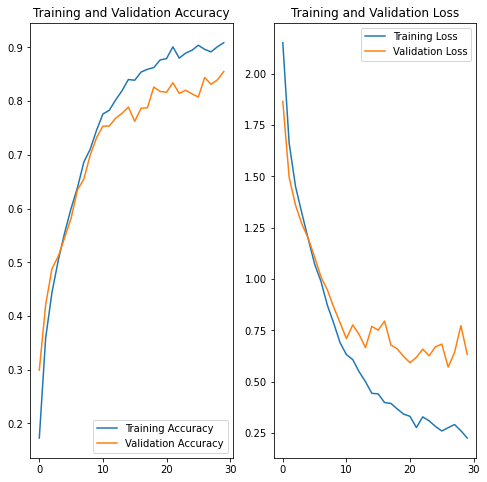

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

After doing class balance using **augmentor** (We took 500 samples for each class) **Underfitting and Overfitting** issues resolved and also Model does well in terms of **Accuracy** and **Loss**.

 - Training accuracy : **90%** 
 - Validation accuracy : **85%**


 - Loss in Training : **0.2254** 
 - Loss in Validation : **0.6331**

Clearly there is no sign of overfitting and underfitting.

So we can say **Class Rebalance** helped to increase model performance in terms of **Accuracy and Loss** .